# Synchornization in complete networks of neurons
Here is the dynamics of neurons potentails in rotational model :
$$
\begin{cases}
\dot{\theta_i}=I_i - cos(\theta_i) -g  E \\
\ddot{E}+ 2\alpha \dot{E}+\alpha^{2}E =\frac{\alpha^{2}}{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
\end{cases}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
num_neurons = 10000
g = 50
random_input_span = (8.5,13.5) #it should fall in the well defined cos(\theta) domain.

total_time = 1000
time_step = 0.01
total_steps = int(total_time/time_step)
time_span = np.arange(0,total_time,time_step)

delay_time = 0.1
delay_step = int(delay_time/time_step)

alpha = 20
m_arr = np.zeros(total_steps)
e_arr = np.zeros(total_steps)

theta_arr = np.zeros(num_neurons,dtype = float)
# theta_arr = np.random.uniform(0,2*np.pi,size = num_neurons)
random_input = np.random.uniform(*random_input_span,size = num_neurons)

In [3]:
saving_path_name = 'single_runs'
current_version = 'N{}_T{}_g{}_input_{}_{}'.format(num_neurons,total_time,g,random_input_span[0],random_input_span[1])
try:
    saving_path = os.path.join(saving_path_name, current_version) 
    os.makedirs(saving_path)
except:
    pass

In [4]:
spiking_records = np.array( np.zeros((total_steps,num_neurons)), dtype = bool )
amin_saman_param = np.zeros( total_steps )

## Instrumentes to capture spiking frequency
Here we use *cornometer* and number of spikies to measure their frequencies.

In [5]:
spiking_cornometer = np.zeros(num_neurons)
total_spikes_intervals = np.zeros(num_neurons)
total_spikes_num = np.zeros(num_neurons)

In [6]:
def retarded_spikes_record(step):
    """
    This is the function which take cares of response delay between spikes and their effects.
    """
    if step > delay_step: 
        return np.sum(spiking_records[step - delay_step])
    else:
        return 0


## "For" loop on the march!
To make equations more solvable we turn them into three cases of linear first order equations:
$$
\begin{cases}
\dot{\theta_i}=I_i - cos(\theta_i) - g E \\
\dot{E} = M - \alpha E\\
\dot{M} = -  \alpha M + \frac{ \alpha^{2} }{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
\end{cases}
$$

In [7]:
for i in tqdm( range(total_steps - 1) ):
    theta_arr = theta_arr + (random_input - np.cos(theta_arr) - g * e_arr[i] )*time_step
    
    #here we should spot the spiking neurons.
    spiking_records[i] = theta_arr > np.pi
    theta_arr = theta_arr - 2 * np.pi * spiking_records[i]
#     theta_arr = theta_arr + 2 * np.pi * (theta_arr < - np.pi)
    #neurons activity
    m_arr[i+1] = m_arr[i] + time_step*( -alpha*m_arr[i] ) + ( (alpha**2)/num_neurons ) *retarded_spikes_record(i) 
    e_arr[i+1] = e_arr[i] + time_step*( m_arr[i] - alpha*e_arr[i] )
    #
    left_handed_neurons = np.cos(theta_arr) < 0
    amin_saman_param[i] = np.mean( np.sin(theta_arr[left_handed_neurons]) )**2
    #frequency calculator
    total_spikes_num = total_spikes_num + spiking_records[i]
    total_spikes_intervals = total_spikes_intervals + spiking_cornometer * spiking_records[i] #add to spike lapsed time
    spiking_cornometer = spiking_cornometer * (spiking_records[i]-1)*(-1) #reset the spikied cornos
    spiking_cornometer = spiking_cornometer + (spiking_records[i]-1)*(-1) #update the not spikied ones
    
    

  0%|                                                                                        | 0/99999 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████████████████████████████████████| 99999/99999 [01:41<00:00, 988.32it/s]


In [8]:
sigma = np.std( e_arr )
sigma

0.25075718579055595

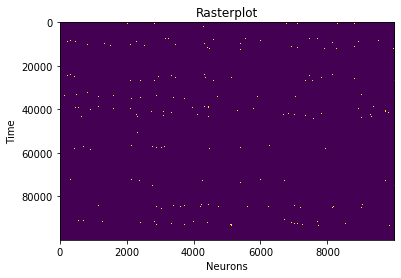

In [9]:
plt.imshow( spiking_records, aspect= 'auto')
plt.xlabel('Neurons')
plt.ylabel('Time')
plt.title('Rasterplot')
plt.savefig( os.path.join(saving_path, 'raster_plot.png'))

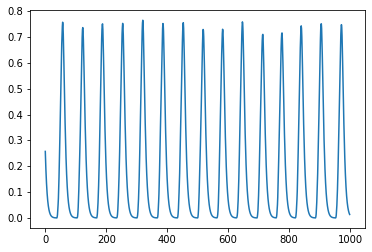

In [10]:
plt.plot(e_arr[-1000:])

In [11]:
random_input - g *e_arr[-1] 

array([12.30057508,  7.84747925, 12.07007964, ...,  8.50997863,
       11.41310489, 10.68593835])

(array([ 270.,  252.,  247.,  274.,  252.,  203.,  182.,  162.,  106.,
        8052.]),
 array([-1323.56013619, -1191.01724314, -1058.47435009,  -925.93145705,
         -793.388564  ,  -660.84567095,  -528.3027779 ,  -395.75988486,
         -263.21699181,  -130.67409876,     1.86879428]),
 <a list of 10 Patch objects>)

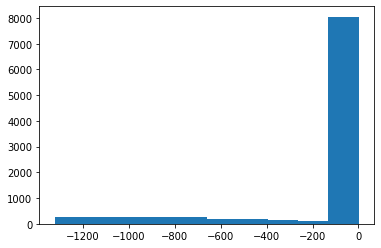

In [12]:
plt.hist(theta_arr )

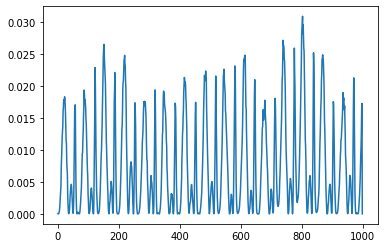

In [13]:
plt.plot(amin_saman_param[-1000:])

In [14]:
np.mean(amin_saman_param[-100:])

0.006520465216368037

## Calculate frequnecy

In [15]:
spikies_period_mean = total_spikes_intervals * time_step / total_spikes_num
spikies_period_mean

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([2.03702869,        nan, 2.20614191, ..., 0.34      , 2.88744928,
       4.42666667])

In [16]:
heights, bins = np.histogram(spikies_period_mean,bins=np.logspace(np.log10(0.1),np.log10(10.0), 20))
# plt.scatter(bins[:-1],heights)
# plt.yscale('log')
# plt.xscale('log')
heights, bins

(array([   0,    0,    0,    0, 1952,  518,    0,    0,    0,    0,    0,
         389, 1435, 1116,  860,  668,  521,  350,  309], dtype=int64),
 array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
         0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
         1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
         3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ]))

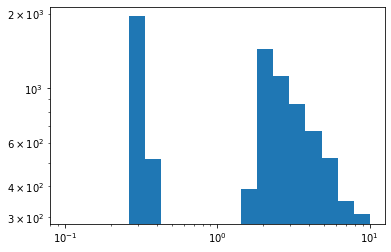

In [17]:
(heights, bins, patches) = plt.hist(spikies_period_mean,bins=np.logspace(np.log10(0.1),np.log10(10.0), 20))
plt.yscale('log')
plt.xscale('log')

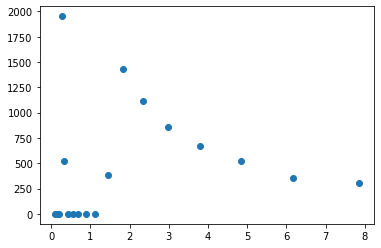

In [18]:
plt.scatter(bins[:-1],heights)
# plt.yscale('log')
# plt.xscale('log')
plt.savefig( os.path.join(saving_path, 'spikies_time_interval.png'))

## Are silent neurons the lower recieved inputs?

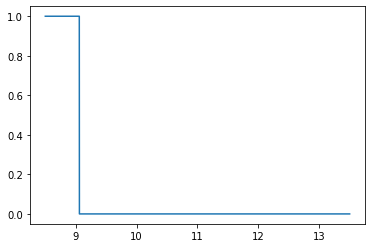

In [19]:
plt.plot(np.sort(random_input), np.isnan( spikies_period_mean[ np.argsort(random_input) ] ) )

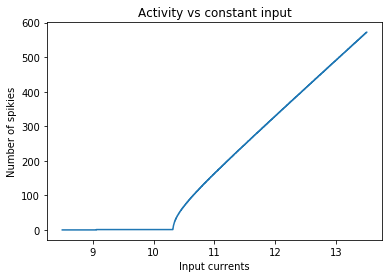

In [20]:
plt.plot(np.sort(random_input), total_spikes_num[ np.argsort(random_input) ] )
plt.xlabel('Input currents')
plt.ylabel('Number of spikies')
plt.title('Activity vs constant input')
plt.savefig(os.path.join(saving_path, 'spikies_num_vs_input.png'))

Text(0.5, 1.0, 'Activity vs constant input')

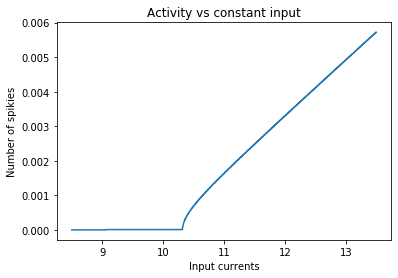

In [21]:
plt.plot(np.sort(random_input), total_spikes_num[ np.argsort(random_input) ]/total_steps )
plt.xlabel('Input currents')
plt.ylabel('Number of spikies')
plt.title('Activity vs constant input')
# plt.savefig(os.path.join(saving_path, 'spikies_num_vs_input.png'))

### Curve fitting

In [22]:
from scipy.optimize import curve_fit

In [23]:
def response_func(i,a,b,i0):
    returned_value = np.zeros(len(i))
    for index in range(len(i)):
        if i[index] > 1/b + i0:
            returned_value[index] = a*(b**2 * (i[index]-i0)**2 - 1)**(1/2) / 2*np.pi
    return returned_value

In [66]:
xdata = np.sort(random_input)
ydata = total_spikes_num[ np.argsort(random_input) ]/total_steps

popt, popv = curve_fit(response_func,xdata,ydata, bounds = (0,[20,20,20]))

Text(0.5, 1.0, 'Curve fitting')

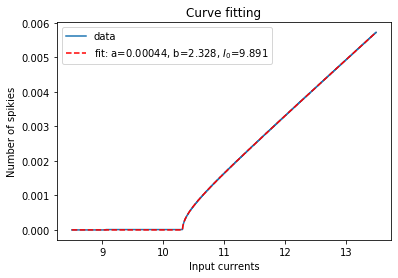

In [67]:
fig,ax = plt.subplots()
ax.plot(xdata, ydata, label = 'data')
ax.plot(xdata, response_func(xdata, *popt), 'r--', label='fit: a=%5.5f, b=%5.3f, $I_0$=%5.3f' % tuple(popt))
plt.legend()
ax.set_xlabel('Input currents')
ax.set_ylabel('Number of spikies')
ax.set_title('Curve fitting')

## Current calculation

In [121]:
i_in_avg = np.mean( -g* e_arr[-100:] )
i_in_avg

-11.96631955273498

In [122]:
def single_neuron_respose(current_array):
    return_response = np.zeros(len(current_array))
    for index in range(len(current_array)):
        if current_array[index] > 1:
            return_response[index] =  np.sqrt(current_array[index]**2 - 1)/ (2*np.pi)
    return return_response

def analytical_current(i_exp_arr):
    computed_current = np.zeros(len(i_exp_arr))
    for index in range(len(i_exp_arr)):
        computed_current[index] = -g * np.mean( single_neuron_respose(random_input + i_exp_arr[index] ) )
    return computed_current

In [124]:
i_in_suspect_range = np.linspace(-13,-8,100)
analytical_current(i_in_suspect_range)

array([-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -4.52965430e-04, -1.96720562e-02,
       -5.33177132e-02, -9.45190095e-02, -1.46769733e-01, -2.06494735e-01,
       -2.72295309e-01, -3.43595176e-01, -4.20361897e-01, -5.05272614e-01,
       -5.93237497e-01, -6.86985948e-01, -7.84940071e-01, -8.85552537e-01,
       -9.95281384e-01, -1.10966248e+00, -1.22923240e+00, -1.35539760e+00,
       -1.48410806e+00, -1.61780613e+00, -1.75810682e+00, -1.90473737e+00,
       -2.05143998e+00, -2.20175927e+00, -2.35894194e+00, -2.51842312e+00,
       -2.68580877e+00, -2.85745931e+00, -3.03157310e+00, -3.20760613e+00,
       -3.39041839e+00, -3.57745038e+00, -3.76921530e+00, -3.96556862e+00,
       -4.16551588e+00, -4.37248905e+00, -4.57890877e+00, -4.79051961e+00,
       -5.00771867e+00, -5.23047967e+00, -5.45962565e+00, -5.69123676e+00,
       -5.92485784e+00, -

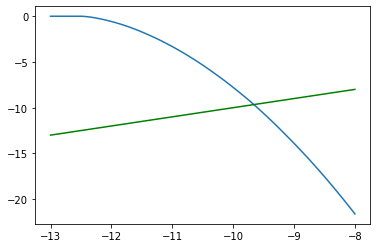

In [126]:
plt.plot(i_in_suspect_range, analytical_current(i_in_suspect_range))
plt.plot(i_in_suspect_range, i_in_suspect_range, 'g')

In [101]:
np.sum( ( random_input ) -10 > 9 )

0